In [6]:
# Replace this line in your notebook:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import torch 

# With this:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

Using device: mps


In [7]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"MPS available: {torch.backends.mps.is_available()}")

if torch.backends.mps.is_available():
    # Quick test
    x = torch.randn(100, 100).to('mps')
    y = torch.randn(100, 100).to('mps')
    z = x @ y
    print("✓ MPS GPU acceleration is working!")

PyTorch version: 2.7.1
MPS available: True
✓ MPS GPU acceleration is working!


In [8]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Access the variables
data_dir = os.getenv('DATA_DIR')
data_dir

'/Users/max/proj/audioClassify/data'

In [9]:
import os
import pandas as pd

# Assuming data_dir is defined earlier in your code
# data_dir = "path_to_your_data_directory"

# Load metadata with features from data directory
metadata_path = os.path.join(data_dir, "metadata_features.json")
if os.path.exists(metadata_path):
    metadata = pd.read_json(metadata_path, orient='records')
    print(f"Metadata loaded from: {metadata_path}")
else:
    print(f"Metadata file not found at: {metadata_path}")
    print("Please run the feature extraction cells above first.")

Metadata loaded from: /Users/max/proj/audioClassify/data/metadata_features.json


In [10]:
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,file_path,features
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,/Users/max/proj/audioClassify/data/UrbanSound8...,"[[-335.0899047852, -176.7096557617, -98.338691..."
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,/Users/max/proj/audioClassify/data/UrbanSound8...,"[[-492.1376037598, -455.0679321289, -449.95037..."
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,/Users/max/proj/audioClassify/data/UrbanSound8...,"[[-496.6634521484, -471.2095947266, -479.95898..."
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,/Users/max/proj/audioClassify/data/UrbanSound8...,"[[-447.4398803711, -412.1046142578, -408.45083..."
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,/Users/max/proj/audioClassify/data/UrbanSound8...,"[[-473.8781433105, -438.3492736816, -442.38864..."


* Creating a featuredf dataframe to store features and their respective categories.

In [11]:
featuresdf = pd.DataFrame()
featuresdf['feature'] = metadata['features']
featuresdf['class_label'] = metadata['class']

featuresdf['class_label'] = pd.Categorical(featuresdf['class_label'])
featuresdf['class_category'] = featuresdf['class_label'].cat.codes

* Instead of categorizing the class column and getting the categorical codes back we could have used the class ids. Same thing!!

In [12]:
featuresdf.head()

,feature,class_label,class_category
0,"[[-335.0899047852, -176.7096557617, -98.338691...",dog_bark,3
1,"[[-492.1376037598, -455.0679321289, -449.95037...",children_playing,2
2,"[[-496.6634521484, -471.2095947266, -479.95898...",children_playing,2
3,"[[-447.4398803711, -412.1046142578, -408.45083...",children_playing,2
4,"[[-473.8781433105, -438.3492736816, -442.38864...",children_playing,2


## Deep Learning Modelling

### Train Test Split
* X are mfcc features.
* y are class categories.
* Since all of the class don't have same instances let's stratify on the y.

In [13]:
from sklearn.model_selection import train_test_split 
X = featuresdf.feature
y = featuresdf.class_category
x_train, x_test, y_train, y_test = train_test_split(list(X.values), list(y.values), test_size=0.2, random_state = 42, stratify=y)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision

from torch.utils.data import TensorDataset,DataLoader

In [16]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print(x_train_tensor.dtype, y_train_tensor.dtype)
print(x_test_tensor.dtype, y_test_tensor.dtype)

torch.float32 torch.int64
torch.float32 torch.int64


In [17]:
print(x_train_tensor.shape, x_test_tensor.shape)

torch.Size([6985, 40, 174]) torch.Size([1747, 40, 174])


### Fixing the shapes of features for Pytorch CNN.
* CNN layers expect the output to be of dimensions ```[batch_size, num_channels, len_y, len_x]```.
* Our x_train_tensor has shape ```[6885, 40, 174]``` it is lacking num_channels dimension,  since the features were 2D we will say that num_channels = 1.
* we will unsqueeze the tensor along the dim=1(where num_channels should be) adding a new dimension as num_channels.

In [18]:
x_train_tensor = x_train_tensor.unsqueeze(1)
x_test_tensor = x_test_tensor.unsqueeze(1)

print(x_train_tensor.shape, x_test_tensor.shape)

torch.Size([6985, 1, 40, 174]) torch.Size([1747, 1, 40, 174])


### Creating Tensor Dataset

In [19]:
train_dataset = TensorDataset(x_train_tensor,y_train_tensor)
test_dataset = TensorDataset(x_test_tensor,y_test_tensor)

### Creating Data Loaders

In [20]:
train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=64*2)

* Setting the device to cuda or cpu depending upon the availiablity.

### Loading created models from github gist.

In [21]:
!git clone https://gist.github.com/ce6fa5ed83c78ce95244fd938b93655a.git
!mv ce6fa5ed83c78ce95244fd938b93655a/* ./
!rm -rf ce6fa5ed83c78ce95244fd938b93655a

Cloning into 'ce6fa5ed83c78ce95244fd938b93655a'...
remote: Enumerating objects: 32, done.
remote: Total 32 (delta 0), reused 0 (delta 0), pack-reused 32 (from 1)
Receiving objects: 100% (32/32), 4.85 KiB | 2.42 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [22]:
from urban_base_model_cnn import UrbanSoundBase

from model_cnn_6_layers_simple import CNNModel_6Layers
from model_cnn_8_layers_simple import CNNModel_8Layers
from model_cnn_4_layers_simple import CNNModel_4Layers
from model_cnn_dynamic import DynamicModel

### Dynamic Deep Learning Model

In [23]:
input = torch.randn(32,1,40,174)
input_channels = 1
cnn_hidden_channels = [16, 32, 32, 64]
hidden_sizes = [128]
output_size = 10
sample_image_batch_dim = (32,1,40,174)
model = DynamicModel(input_channels, cnn_hidden_channels, hidden_sizes, output_size, sample_image_batch_dim)
model = model.to(device)

### Sample Model Architecture : Customizable Model

In [24]:
model

DynamicModel(
  (layers): ModuleList(
    (0): Sequential(
      (conv_layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
      (max_pool_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (relu_layer): ReLU()
    )
    (1): Sequential(
      (conv_layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
      (relu_layer): ReLU()
    )
    (2): Sequential(
      (conv_layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (max_pool_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (relu_layer): ReLU()
    )
    (3): Sequential(
      (conv_layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (relu_layer): ReLU()
    )
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Sequential(
      (linear_layer): Linear(in_features=12480, out_features=128, bias=True)
      (relu_layer): ReLU()
    )
    (6): Sequential(
      (linear_layer): Linear(in_features=128, out_features=10, bias=True)
 

### Model Accuracy and Loss before Training

In [25]:
model.eval()
valid_history = model.evaluate_validation(test_dl, device)
acc = torch.stack([valid['val_acc'] for valid in valid_history]).mean().item()
loss = torch.stack([valid['val_loss'] for valid in valid_history]).mean().item()

print(f"Accuracy : {acc:.3f}, Loss : {loss:.3f}")

Accuracy : 0.102, Loss : 2.324


In [26]:
def fit(model,train_dataloader, valid_dataloader, n_epochs,lr = 0.001, optim = torch.optim.Adam, device = device):
  model_history = {'train_loss' : [], 'valid_loss' : [], 'train_acc' : [], 'valid_acc' : []}
  optimizer = optim(model.parameters(), lr)

  for epoch in range(n_epochs):
    model.train()
    train_loss = []
    train_accuracy = []

    for image_label_batch in train_dataloader:
      image, label = image_label_batch[0].to(device), image_label_batch[1].to(device)
      loss_acc = model.training_step((image, label))
      loss = loss_acc['loss']
      acc = loss_acc['acc']
      loss.backward()
      train_loss.append(loss)
      train_accuracy.append(acc)

      optimizer.step()
      optimizer.zero_grad()
    
    model.eval()
    
    with torch.no_grad():
        val_history = model.evaluate_validation(valid_dataloader, device)
        result = model.epoch_end(val_history)

    model_history['train_loss'].append(torch.stack(train_loss).mean().item())
    model_history['valid_loss'].append(result['val_loss'])
    model_history['train_acc'].append(torch.stack(train_accuracy).mean().item())
    model_history['valid_acc'].append(result['val_acc'])
    print(f"Epoch : {epoch}, Train Loss : {model_history['train_loss'][-1]:.2f}, Train Accuracy : {model_history['train_acc'][-1]:.2f}, Validation Loss : {result['val_loss']:.2f}, Validation Accuracy : {result['val_acc']:.2f}")


  return model_history

### Training, Validating Pre-Designed CNN Models

#### 4 Layer CNN Model from ```model_cnn_4_layers_simple.py```

In [27]:
sample_image_batch_dim = (32,1,40,174)
sample_row_size,sample_col_size = 40,174

model = CNNModel_4Layers(10, sample_row_size, sample_col_size)
model = model.to(device)

history_CNNModel_4Layers = fit(model, train_dl, test_dl, 50, 0.001, optim=torch.optim.SGD)

Epoch : 0, Train Loss : 2.22, Train Accuracy : 0.48, Validation Loss : 1.50, Validation Accuracy : 0.45
Epoch : 1, Train Loss : 1.01, Train Accuracy : 0.66, Validation Loss : 1.27, Validation Accuracy : 0.54
Epoch : 2, Train Loss : 0.82, Train Accuracy : 0.73, Validation Loss : 1.08, Validation Accuracy : 0.61
Epoch : 3, Train Loss : 0.71, Train Accuracy : 0.76, Validation Loss : 0.90, Validation Accuracy : 0.69
Epoch : 4, Train Loss : 0.62, Train Accuracy : 0.80, Validation Loss : 0.82, Validation Accuracy : 0.73
Epoch : 5, Train Loss : 0.54, Train Accuracy : 0.82, Validation Loss : 0.72, Validation Accuracy : 0.77
Epoch : 6, Train Loss : 0.48, Train Accuracy : 0.85, Validation Loss : 1.05, Validation Accuracy : 0.67
Epoch : 7, Train Loss : 0.43, Train Accuracy : 0.87, Validation Loss : 0.86, Validation Accuracy : 0.70
Epoch : 8, Train Loss : 0.37, Train Accuracy : 0.89, Validation Loss : 0.57, Validation Accuracy : 0.82
Epoch : 9, Train Loss : 0.32, Train Accuracy : 0.90, Validation 

/var/folders/wk/8vd029mj3mbgl94lf5r5m9080000gn/T/ipykernel_64094/346076381.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


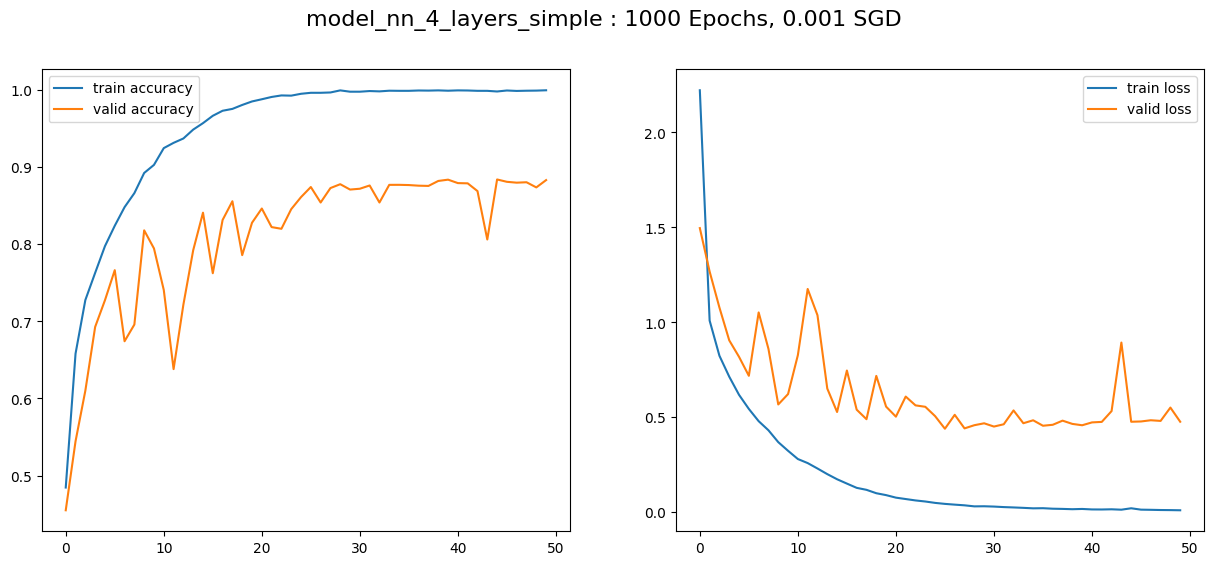

In [37]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

fig.suptitle(f"model_nn_4_layers_simple : 1000 Epochs, 0.001 SGD", fontsize=16)
ax1.plot(history_CNNModel_4Layers['train_acc'], label='train accuracy')
ax1.plot(history_CNNModel_4Layers['valid_acc'], label='valid accuracy')
ax1.legend()


ax2.plot(history_CNNModel_4Layers['train_loss'], label='train loss')
ax2.plot(history_CNNModel_4Layers['valid_loss'], label='valid loss')
ax2.legend()

fig.show()

#### 6 Layer CNN Model from ```model_cnn_6_layers_simple.py```

In [29]:
sample_image_batch_dim = (32,1,40,174)
sample_row_size,sample_col_size = 40,174

model = CNNModel_6Layers(10, sample_row_size, sample_col_size)
model = model.to(device)

history_CNNModel_6Layers = fit(model, train_dl, test_dl, 50, 0.001, optim=torch.optim.SGD)

Epoch : 0, Train Loss : 2.08, Train Accuracy : 0.24, Validation Loss : 1.95, Validation Accuracy : 0.29
Epoch : 1, Train Loss : 1.75, Train Accuracy : 0.38, Validation Loss : 1.76, Validation Accuracy : 0.38
Epoch : 2, Train Loss : 1.54, Train Accuracy : 0.45, Validation Loss : 1.60, Validation Accuracy : 0.46
Epoch : 3, Train Loss : 1.44, Train Accuracy : 0.49, Validation Loss : 1.45, Validation Accuracy : 0.49
Epoch : 4, Train Loss : 1.36, Train Accuracy : 0.53, Validation Loss : 1.49, Validation Accuracy : 0.50
Epoch : 5, Train Loss : 1.29, Train Accuracy : 0.56, Validation Loss : 1.42, Validation Accuracy : 0.51
Epoch : 6, Train Loss : 1.22, Train Accuracy : 0.58, Validation Loss : 1.42, Validation Accuracy : 0.50
Epoch : 7, Train Loss : 1.17, Train Accuracy : 0.60, Validation Loss : 1.22, Validation Accuracy : 0.60
Epoch : 8, Train Loss : 1.11, Train Accuracy : 0.63, Validation Loss : 1.19, Validation Accuracy : 0.61
Epoch : 9, Train Loss : 1.07, Train Accuracy : 0.64, Validation 

/var/folders/wk/8vd029mj3mbgl94lf5r5m9080000gn/T/ipykernel_64094/393901142.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


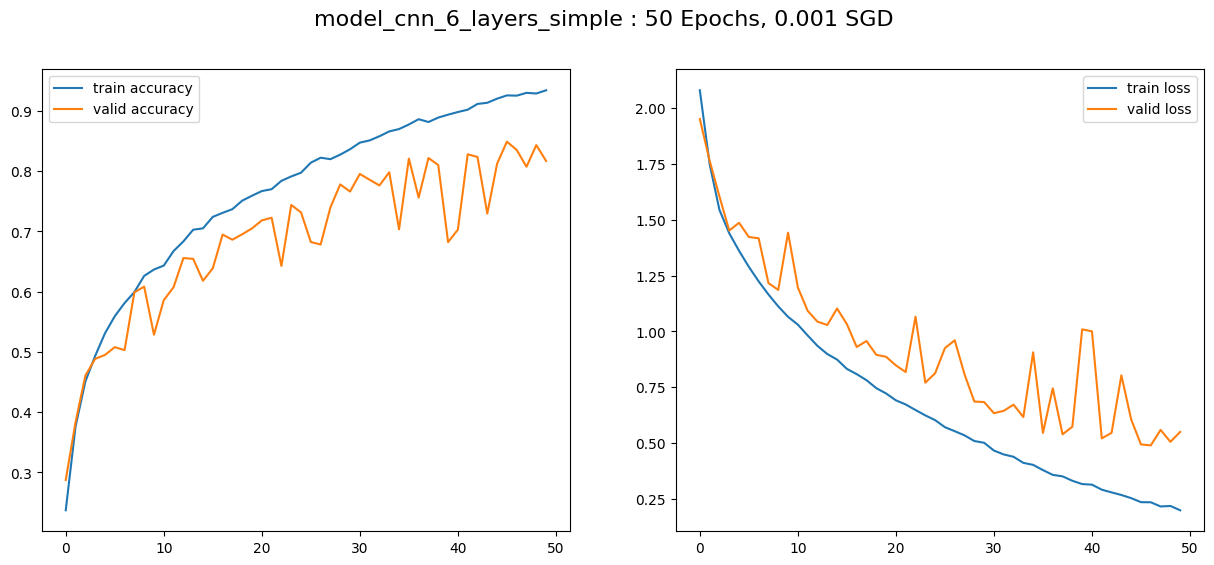

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

fig.suptitle(f"model_cnn_6_layers_simple : 50 Epochs, 0.001 SGD", fontsize=16)
ax1.plot(history_CNNModel_6Layers['train_acc'], label='train accuracy')
ax1.plot(history_CNNModel_6Layers['valid_acc'], label='valid accuracy')
ax1.legend()


ax2.plot(history_CNNModel_6Layers['train_loss'], label='train loss')
ax2.plot(history_CNNModel_6Layers['valid_loss'], label='valid loss')
ax2.legend()

fig.show()

#### 8 Layer CNN Model from ```model_cnn_8_layers_simple.py```

In [31]:
sample_image_batch_dim = (32,1,40,174)
sample_row_size,sample_col_size = 40,174

model = CNNModel_8Layers(10, sample_row_size, sample_col_size)
model = model.to(device)

history_CNNModel_8Layers = fit(model, train_dl, test_dl, 50, 0.001, optim=torch.optim.SGD)

Epoch : 0, Train Loss : 2.30, Train Accuracy : 0.10, Validation Loss : 2.30, Validation Accuracy : 0.15
Epoch : 1, Train Loss : 2.29, Train Accuracy : 0.11, Validation Loss : 2.29, Validation Accuracy : 0.11
Epoch : 2, Train Loss : 2.27, Train Accuracy : 0.11, Validation Loss : 2.27, Validation Accuracy : 0.11
Epoch : 3, Train Loss : 2.25, Train Accuracy : 0.12, Validation Loss : 2.25, Validation Accuracy : 0.12
Epoch : 4, Train Loss : 2.23, Train Accuracy : 0.12, Validation Loss : 2.22, Validation Accuracy : 0.13
Epoch : 5, Train Loss : 2.21, Train Accuracy : 0.13, Validation Loss : 2.20, Validation Accuracy : 0.14
Epoch : 6, Train Loss : 2.20, Train Accuracy : 0.14, Validation Loss : 2.19, Validation Accuracy : 0.20
Epoch : 7, Train Loss : 2.19, Train Accuracy : 0.15, Validation Loss : 2.18, Validation Accuracy : 0.18
Epoch : 8, Train Loss : 2.18, Train Accuracy : 0.16, Validation Loss : 2.17, Validation Accuracy : 0.18
Epoch : 9, Train Loss : 2.16, Train Accuracy : 0.18, Validation 

/var/folders/wk/8vd029mj3mbgl94lf5r5m9080000gn/T/ipykernel_64094/2691285396.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


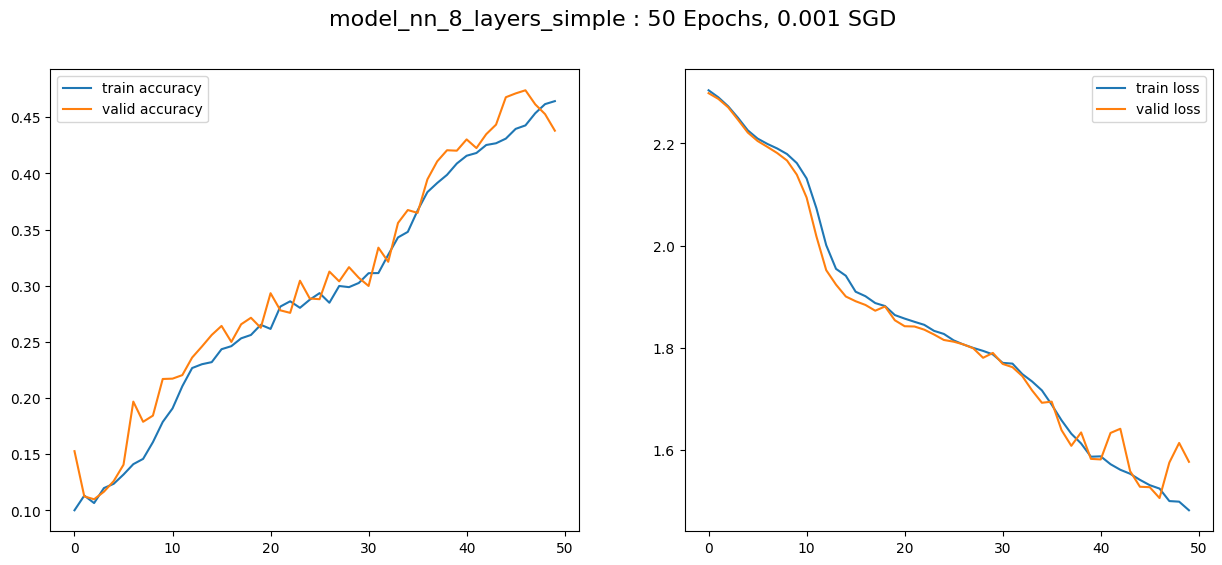

In [32]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

fig.suptitle(f"model_nn_8_layers_simple : 50 Epochs, 0.001 SGD", fontsize=16)
ax1.plot(history_CNNModel_8Layers['train_acc'], label='train accuracy')
ax1.plot(history_CNNModel_8Layers['valid_acc'], label='valid accuracy')
ax1.legend()


ax2.plot(history_CNNModel_8Layers['train_loss'], label='train loss')
ax2.plot(history_CNNModel_8Layers['valid_loss'], label='valid loss')
ax2.legend()

fig.show()

### Training, Validating Pre Designed Models

In [33]:
input = torch.randn(32,1,40,174)
input_channels = 1
cnn_hidden_channels = [16, 32, 32, 64]
hidden_sizes = [128]
output_size = 10
sample_image_batch_dim = (32,1,40,174)
model = DynamicModel(input_channels, cnn_hidden_channels, hidden_sizes, output_size, sample_image_batch_dim)
model = model.to(device)

history_dynamic_6_layers = fit(model, train_dl, test_dl, 50, 0.001, optim=torch.optim.SGD)

Epoch : 0, Train Loss : 2.12, Train Accuracy : 0.20, Validation Loss : 2.02, Validation Accuracy : 0.23
Epoch : 1, Train Loss : 1.76, Train Accuracy : 0.37, Validation Loss : 1.78, Validation Accuracy : 0.33
Epoch : 2, Train Loss : 1.54, Train Accuracy : 0.45, Validation Loss : 1.75, Validation Accuracy : 0.36
Epoch : 3, Train Loss : 1.43, Train Accuracy : 0.49, Validation Loss : 1.63, Validation Accuracy : 0.42
Epoch : 4, Train Loss : 1.32, Train Accuracy : 0.55, Validation Loss : 1.56, Validation Accuracy : 0.46
Epoch : 5, Train Loss : 1.25, Train Accuracy : 0.57, Validation Loss : 1.55, Validation Accuracy : 0.51
Epoch : 6, Train Loss : 1.16, Train Accuracy : 0.61, Validation Loss : 1.24, Validation Accuracy : 0.57
Epoch : 7, Train Loss : 1.12, Train Accuracy : 0.62, Validation Loss : 1.73, Validation Accuracy : 0.46
Epoch : 8, Train Loss : 1.08, Train Accuracy : 0.64, Validation Loss : 1.63, Validation Accuracy : 0.49
Epoch : 9, Train Loss : 1.02, Train Accuracy : 0.65, Validation 

/var/folders/wk/8vd029mj3mbgl94lf5r5m9080000gn/T/ipykernel_64094/2289012854.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


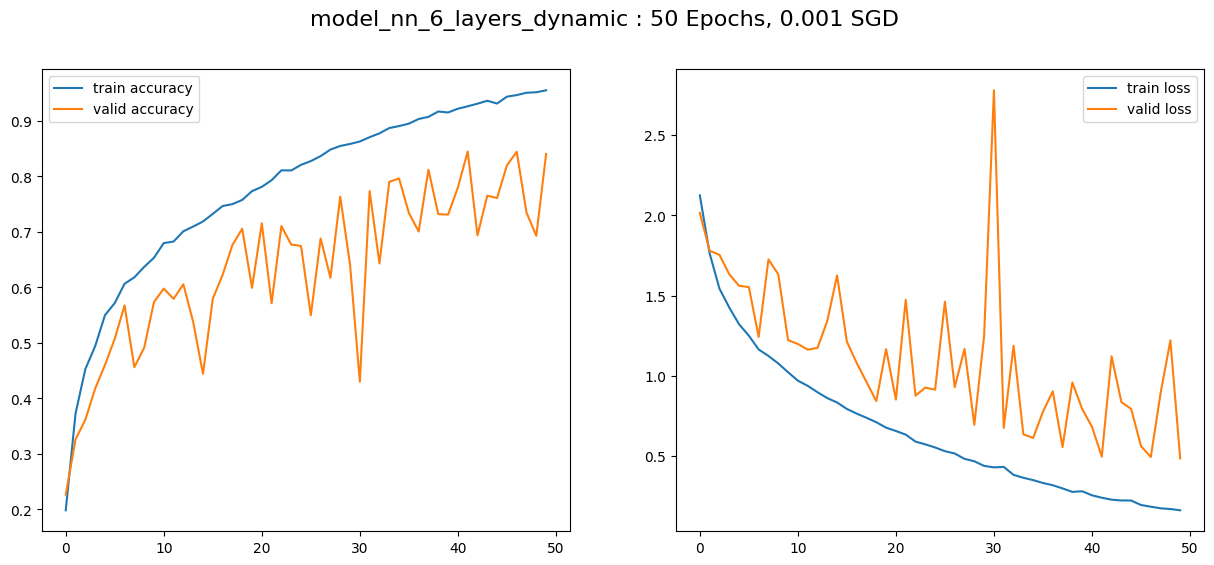

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

fig.suptitle(f"model_nn_6_layers_dynamic : 50 Epochs, 0.001 SGD", fontsize=16)
ax1.plot(history_dynamic_6_layers['train_acc'], label='train accuracy')
ax1.plot(history_dynamic_6_layers['valid_acc'], label='valid accuracy')
ax1.legend()


ax2.plot(history_dynamic_6_layers['train_loss'], label='train loss')
ax2.plot(history_dynamic_6_layers['valid_loss'], label='valid loss')
ax2.legend()

fig.show()

### Different Model(Hidden Channels, Hidden Sizes & Optimizers)

In [35]:
input = torch.randn(32,1,40,174)
input_channels = 1
cnn_hidden_channels = [16, 32, 64, 64]
hidden_sizes = [256]
output_size = 10
sample_image_batch_dim = (32,1,40,174)
model = DynamicModel(input_channels, cnn_hidden_channels, hidden_sizes, output_size, sample_image_batch_dim)
model = model.to(device)

history_dynamic_6_layers_2 = fit(model, train_dl, test_dl, 50, 0.001, optim=torch.optim.Adam)

Epoch : 0, Train Loss : 1.36, Train Accuracy : 0.52, Validation Loss : 1.06, Validation Accuracy : 0.62
Epoch : 1, Train Loss : 0.75, Train Accuracy : 0.75, Validation Loss : 0.65, Validation Accuracy : 0.78
Epoch : 2, Train Loss : 0.52, Train Accuracy : 0.83, Validation Loss : 0.61, Validation Accuracy : 0.80
Epoch : 3, Train Loss : 0.37, Train Accuracy : 0.87, Validation Loss : 0.44, Validation Accuracy : 0.85
Epoch : 4, Train Loss : 0.27, Train Accuracy : 0.91, Validation Loss : 0.51, Validation Accuracy : 0.84
Epoch : 5, Train Loss : 0.21, Train Accuracy : 0.93, Validation Loss : 0.43, Validation Accuracy : 0.86
Epoch : 6, Train Loss : 0.18, Train Accuracy : 0.94, Validation Loss : 0.44, Validation Accuracy : 0.86
Epoch : 7, Train Loss : 0.12, Train Accuracy : 0.96, Validation Loss : 0.48, Validation Accuracy : 0.86
Epoch : 8, Train Loss : 0.09, Train Accuracy : 0.97, Validation Loss : 0.56, Validation Accuracy : 0.86
Epoch : 9, Train Loss : 0.10, Train Accuracy : 0.97, Validation 

/var/folders/wk/8vd029mj3mbgl94lf5r5m9080000gn/T/ipykernel_64094/3644854393.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


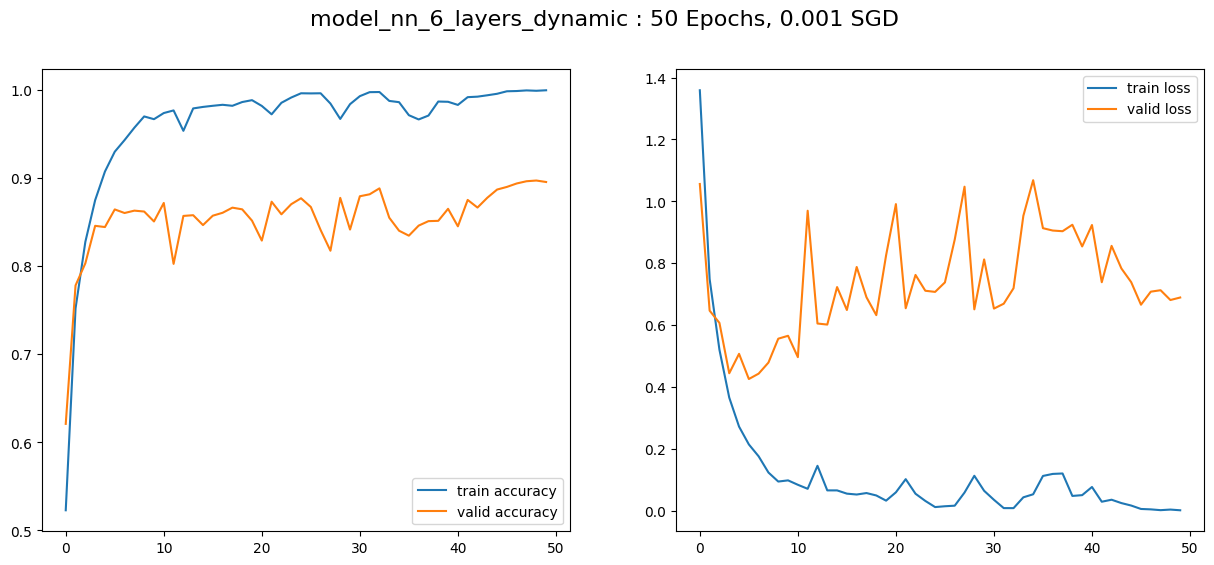

In [36]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

fig.suptitle(f"model_nn_6_layers_dynamic : 50 Epochs, 0.001 SGD", fontsize=16)
ax1.plot(history_dynamic_6_layers_2['train_acc'], label='train accuracy')
ax1.plot(history_dynamic_6_layers_2['valid_acc'], label='valid accuracy')
ax1.legend()

ax2.plot(history_dynamic_6_layers_2['train_loss'], label='train loss')
ax2.plot(history_dynamic_6_layers_2['valid_loss'], label='valid loss')
ax2.legend()

fig.show()

## Future Scopes:
* Just as we expected CNN to perform better on MFCC, maybe RNN can be perform better than them.
* Experiment with multiple architectures to find some more insights into model behaviours.